In [1]:
import sys
import paddle
sys.path.append("./work")

PLACE = paddle.CUDAPlace(0)
# print(paddle.device.get_device())
paddle.device.set_device('gpu:0')

Place(gpu:0)

In [2]:
from model import LatentModulatedSiren # 这个就是我们的模型F_theta
from utils import get_coordinate_grid
from paddle.vision.models import resnet34
from dataloaders import create_dataloader

In [3]:
from paddle.vision import transforms
import dataloaders.mnist as mnist
import paddle
def test_dataloader(dset, dset_root=None, batch_size=8):
    """Create dataloader for selected dataset"""
    if dset == "mnist":
        transform = transforms.Compose([
            transforms.ToTensor()
        ])
        dataset = mnist.Mnist(split='test',transforms=transform)
    elif dset == "cifar10":
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        dataset = mnist.Cifar(split='test',transforms=transform)
    # Other options...

    dataloader = paddle.io.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=2,
    )

    return dataloader

In [4]:
import paddle.nn as nn
def inner_loop(images, coords, network, optim, 
                criterion=nn.MSELoss(reduction='none'), modulate=None, meta_sgd=False):
    best_loss=1e7
    best_recon=None
    network.train()
    for i in range(5):
        #network.clear_gradients()
        recon = network(coords, modulate)

        loss = criterion(recon, images) # N, H, W, C
        loss = loss.mean([1, 2, 3]).sum(0)
        # print(i)
        loss.backward()
        
        optim.step()
        optim.clear_grad()
        if best_loss>loss[0]:
            best_loss=loss[0]
            best_recon=recon
    
    return best_loss,best_recon

In [5]:
model_cfg = {
    'batch_size': 16,
    'out_channels': 1, # Gray
    'depth': 15,
    'latent_dim': 512,
    'latent_init_scale': 0.01,
    'layer_sizes': [],
    'meta_sgd_clip_range': [0, 1],
    'meta_sgd_init_range': [0.005, 0.1],
    'modulate_scale': False,
    'modulate_shift': True,
    'use_meta_sgd': True,
    'w0': 30,
    'width': 512}

In [6]:
model_mnist = LatentModulatedSiren(**model_cfg)
state_dict = paddle.load("./work/assets/mnist_params_512_latents_100000.pdparams")
model_mnist.set_state_dict(state_dict)

W0617 21:51:26.755360  5113 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0617 21:51:26.760283  5113 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1492: UserWarning: Skip loading for meta_sgd_lrs.meta_sgd_lrs. meta_sgd_lrs.meta_sgd_lrs is not found in the provided dict.
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/layers.py:1492: UserWarning: Skip loading for latent.latent_vector. latent.latent_vector receives a shape [128, 512], but the expected shape is [16, 512].
  warnings.warn(("Skip loading for {}. ".format(key) + str(err)))


In [7]:
dataloader_test_mnist=test_dataloader(dset='mnist',batch_size=16)
dataloader_train_mnist=create_dataloader.create_dataloader(dset='mnist',batch_size=16)

shape of X: (10000, 32, 32), y: (10000,)
shape of X: (60000, 32, 32), y: (60000,)


In [8]:
import paddle
import paddle.nn.functional as F
class LeNet(paddle.nn.Layer):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = paddle.nn.Conv2D(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.max_pool1 = paddle.nn.MaxPool2D(kernel_size=2,  stride=2)
        self.conv2 = paddle.nn.Conv2D(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.max_pool2 = paddle.nn.MaxPool2D(kernel_size=2, stride=2)
        self.linear1 = paddle.nn.Linear(in_features=576, out_features=120)
        self.linear2 = paddle.nn.Linear(in_features=120, out_features=84)
        self.linear3 = paddle.nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool2(x)
        x = paddle.flatten(x, start_axis=1,stop_axis=-1)
        # print(x.shape)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        return x


classifier=LeNet()

In [9]:
criterion = paddle.nn.MSELoss('none') # 自定义逻辑，重建结果样本内mean，样本间sum
inner_optim = paddle.optimizer.SGD(1e-2, parameters=[model_mnist.latent.latent_vector]) # 内圈优化只调整phi

In [10]:
from paddle.metric import Accuracy
import numpy as np
def cross_validation(model, classifier, dataloader, metric):
    classifier.eval()
    metric.reset()
    inner_optim=paddle.optimizer.SGD(3e-3,parameters=[model.latent.latent_vector])
    inner_criterion = paddle.nn.MSELoss(reduction='none')
    for batch_data in dataloader:
        imgs, coords, labels, idxs = batch_data
        paddle.assign(
            np.zeros(model.latent.latent_vector.shape).astype("float32"),
            model.latent.latent_vector)
        _, features = inner_loop(imgs,coords,model,inner_optim,inner_criterion)
        features=features.transpose((0,3,1,2))
        inner_optim.clear_grad()
        with paddle.no_grad():
            outputs = classifier(features)
            metric.update(metric.compute(outputs, labels))
    
    accuracy = metric.accumulate()
    return accuracy

In [11]:
import numpy as np

def train_mnist(lr, model, classifier, train_dataloader, test_dataloader, num_epochs):
    criterion = paddle.nn.CrossEntropyLoss()
    optimizer = paddle.optimizer.Adam(lr,parameters=classifier.parameters(),weight_decay=1e-4)
    inner_optim=paddle.optimizer.SGD(1e-2,parameters=[model.latent.latent_vector])
    inner_criterion = paddle.nn.MSELoss(reduction='none')
    metric = Accuracy()
    # modulate = model.latent.latent_vector.detach()
    for epoch in range(num_epochs):
        classifier.train()
        for i,batch_data in enumerate(train_dataloader):
            #print(i)
            paddle.assign(
            np.zeros(model.latent.latent_vector.shape).astype("float32"),
            model.latent.latent_vector,
        )
            optimizer.clear_grad()
            # classifier.clear_gradients()
            imgs, coords, labels, idxs = batch_data
            # print(imgs.shape,modulate.shape)
            #imgs=imgs.transpose((0,2,3,1))
            _, features = inner_loop(imgs,coords,model,inner_optim,inner_criterion)
            features=features.transpose((0,3,1,2))
            features_2=features.detach()
            features.stop_gradient=True
            features_2.stop_gradient=False
            outputs = classifier(features_2)
            outer_loss = criterion(outputs, labels)
            
            outer_loss.backward()
            optimizer.step()
        
        accuracy = cross_validation(model, classifier, test_dataloader, metric)
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}")

In [18]:
paddle.device.cuda.empty_cache()

In [12]:
train_mnist(1e-3,model_mnist,classifier,dataloader_train_mnist,dataloader_test_mnist,5)

Epoch [1/5], Accuracy: 0.9371
Epoch [2/5], Accuracy: 0.9545
Epoch [3/5], Accuracy: 0.9523
Epoch [4/5], Accuracy: 0.9540


KeyboardInterrupt: 

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:425: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_min = np.asscalar(a_min.astype(scaled_dtype))
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/image.py:426: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  a_max = np.asscalar(a_max.astype(scaled_dtype))


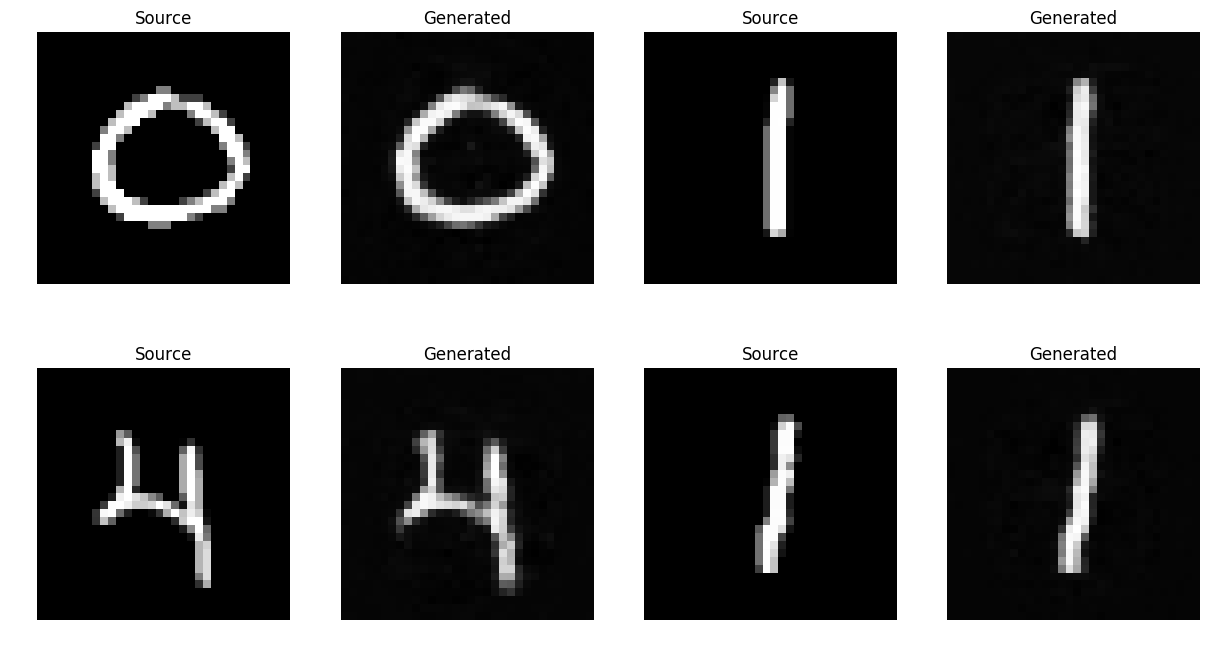

In [16]:
plt.figure(figsize=(15, 8))

for i in range(model_cfg['batch_size']):
    plt.subplot(2, model_cfg['batch_size'], i * 2 + 1)
    plt.imshow(images[i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Source")

    plt.subplot(2, model_cfg['batch_size'], i * 2 + 2)
    plt.imshow(pp_out[i, ..., 0].numpy(), cmap='gray')
    plt.axis("off")
    plt.title("Generated")

In [14]:
import os
paddle.save(classifier.state_dict(), os.path.join("./output/", 'lenet.pdparams'))